In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

#README  https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [15]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    tmp_save = pickle.load(f)
    tmp_train_dataset = tmp_save['train_dataset']
    tmp_train_labels = tmp_save['train_labels']
    tmp_valid_dataset = tmp_save['valid_dataset']
    tmp_valid_labels = tmp_save['valid_labels']
    tmp_test_dataset = tmp_save['test_dataset']
    tmp_test_labels = tmp_save['test_labels']
    
    print('Training set', tmp_train_dataset.shape, tmp_train_labels.shape)
    print('Validation set', tmp_valid_dataset.shape, tmp_valid_labels.shape)
    print('Test set', tmp_test_dataset.shape, tmp_test_labels.shape)
    del tmp_save
    
def shuffle(dataset, labels):
    indexes = np.arange(labels.shape[0])
    np.random.shuffle(indexes)
    return dataset[indexes], labels[indexes]

tmp_train_dataset, tmp_train_labels = shuffle(tmp_train_dataset, tmp_train_labels)
tmp_valid_dataset, tmp_valid_labels = shuffle(tmp_valid_dataset, tmp_valid_labels)
tmp_test_dataset, tmp_test_labels = shuffle(tmp_test_dataset, tmp_test_labels)

Training set (20000, 90, 160) (20000,)
Validation set (2000, 90, 160) (2000,)
Test set (6000, 90, 160) (6000,)


In [16]:
# Lets only train on pics with n digits
num_digits = 5

keep = [i for i, label in enumerate(tmp_train_labels) if len(label) <= num_digits]
tmp_train_dataset = tmp_train_dataset[keep]
tmp_train_labels = tmp_train_labels[keep]

keep = [i for i, label in enumerate(tmp_valid_labels) if len(label) <= num_digits]
tmp_valid_dataset = tmp_valid_dataset[keep]
tmp_valid_labels = tmp_valid_labels[keep]

keep = [i for i, label in enumerate(tmp_test_labels) if len(label) <= num_digits]
tmp_test_dataset = tmp_test_dataset[keep]
tmp_test_labels = tmp_test_labels[keep]

print('Training set', tmp_train_dataset.shape, tmp_train_labels.shape)
print('Validation set', tmp_valid_dataset.shape, tmp_valid_labels.shape)
print('Test set', tmp_test_dataset.shape, tmp_test_labels.shape)

Training set (20000, 90, 160) (20000,)
Validation set (2000, 90, 160) (2000,)
Test set (6000, 90, 160) (6000,)


In [17]:
shrink_by = 2
tmp_train_dataset = tmp_train_dataset[:, ::shrink_by, ::shrink_by]
tmp_valid_dataset = tmp_valid_dataset[:, ::shrink_by, ::shrink_by]
tmp_test_dataset = tmp_test_dataset[:, ::shrink_by, ::shrink_by]

Labels [4 1]
Dtype float32
Shape (45, 80)
Color range -0.436166 0.491779


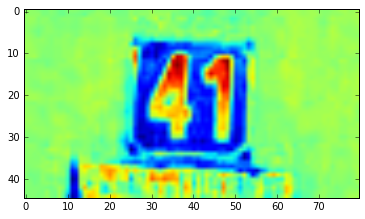

Labels [1 5]
Dtype float32
Shape (45, 80)
Color range -0.475735 0.496328


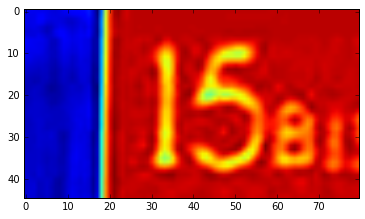

Labels [2]
Dtype float32
Shape (45, 80)
Color range -0.493828 0.320452


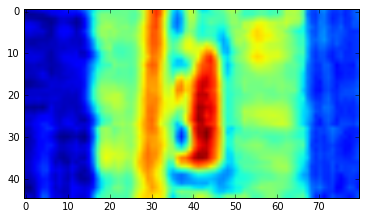

In [18]:
def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    if len(img.shape) > 2:
        plt.imshow(np.reshape(img, img.shape[:2]))
    else:
        plt.imshow(img)
    plt.show()
    
def show_images(imgs, labels, num=3):
    for i in range(num):
        num = np.random.randint(imgs.shape[0])
        show_image(imgs[num], labels[num])
    
show_images(tmp_train_dataset, tmp_train_labels, 1)
show_images(tmp_valid_dataset, tmp_valid_labels, 1)
show_images(tmp_test_dataset, tmp_test_labels, 1)

In [19]:
num_labels = 11 # Add an extra character so we can deal with spaces
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([np.array([(np.arange(num_labels) == l).astype(np.float32) 
                        for l in np.append(row, [num_labels-1] * (num_digits - len(row)), 0)])
              for row in labels])
    #labels_output = np.reshape(labels_output, [labels_output.shape[0], -1])
    return dataset_output, labels_output

train_dataset, train_labels = reformat(tmp_train_dataset, tmp_train_labels)
valid_dataset, valid_labels = reformat(tmp_valid_dataset, tmp_valid_labels)
test_dataset, test_labels = reformat(tmp_test_dataset, tmp_test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (20000, 45, 80, 1) (20000, 5, 11)
Validation set (2000, 45, 80, 1) (2000, 5, 11)
Test set (6000, 45, 80, 1) (6000, 5, 11)


Labels [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Dtype float32
Shape (45, 80, 1)
Color range -0.486267 0.478768


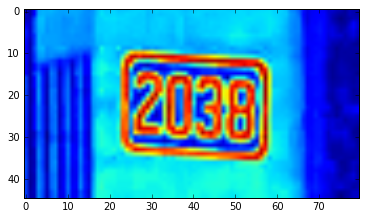

Labels [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Dtype float32
Shape (45, 80, 1)
Color range -0.5 0.491052


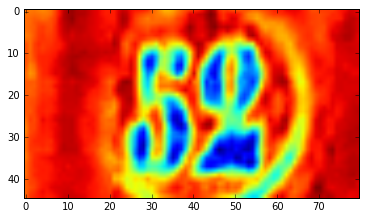

Labels [[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Dtype float32
Shape (45, 80, 1)
Color range -0.5 0.494922


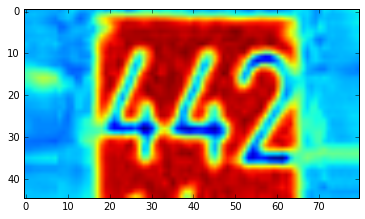

In [20]:
for i in np.random.choice(range(train_labels.shape[0]), 3):
    show_image(train_dataset[i], train_labels[i])

In [21]:
# Clean up after ourselves
%reset_selective -f tmp_.*

In [22]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_list(predictions, labels):
    result = np.mean([accuracy(predictions[i],
                               labels[:, i, :])
                        for i in range(num_digits)])
    return result

def run_graph(graph):
    save_steps = 20000
    eval_steps = 1000
    valid_steps = 1000

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver()
        print('Initialized')
        for step in range(num_steps):

            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]


            feed_dict = {tf_train_labels[i] : batch_labels[:, i, :] for i in range(num_digits)}
            feed_dict[tf_train_dataset] = batch_data        


            fetches = [optimizer, loss]
            results = session.run(fetches, feed_dict=feed_dict)


            if (step % eval_steps == 0):
                print('Learning rate:', learning_rate.eval())
                print('Minibatch loss at step %d: %f' % (step, results[1]))

                fetches = train_prediction
                results = session.run(fetches, feed_dict={tf_train_dataset : batch_data})
                train_accuracy = accuracy_list(
                    results,
                    batch_labels)

                print('Minibatch accuracy: %.1f%%' % train_accuracy)

            if step > 0:
                if (step % valid_steps == 0):
                    valid_accuracy = accuracy_list(
                        [valid_prediction[i].eval() for i in range(num_digits)],
                        valid_labels)
                    print('Validation accuracy: %.1f%%' % valid_accuracy)

                if step % save_steps == 0:
                    #print("Saving")
                    #save_path = saver.save(session, "saves/model%d.ckpt" % step)

                    test_accuracy = accuracy_list(
                        [test_prediction[i].eval() for i in range(num_digits)],
                        test_labels)
                    print('Test accuracy: %.1f%%' % test_accuracy)

        print("Creating outputs")
    #     output = {
    #         'layer_1' : layer1_weights.eval(),
    #         'layer_2' : layer2_weights.eval(),
    #         'layer_3' : layer3_weights.eval(),
    #     }
    print("Finished")

In [11]:
num_steps = 100001
batch_size = 50

patch_size = 5
depth = 32

patch_size2 = 5
depth2 = 64

# Taken from tensorflow tutorial
num_hidden = 1024

graph = tf.Graph()

img_height = 90
img_width = 160
num_channels=1
num_labels=11
num_digits=5
test_dataset = np.ones([batch_size, img_height, img_width, 1])
valid_dataset = test_dataset
train_dataset = test_dataset

stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size2,
                                                    patch_size2,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([60 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        print(data.get_shape().as_list())
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        print(conv.get_shape().as_list())
        hidden = tf.nn.relu(conv + layer1_biases)
        print(hidden.get_shape().as_list())
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        print(hidden.get_shape().as_list())
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        print(conv.get_shape().as_list())
        hidden = tf.nn.relu(conv + layer2_biases)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        print(hidden.get_shape().as_list())
        
        shape = hidden.get_shape().as_list()

        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        print(reshape.get_shape().as_list())
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
                
        if dropout:
            hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    # Lets sum up the errors for each digit
    #loss = tf.add_n(loss_per_digit)
    #loss = tf.add_n(loss_per_digit)
    
    
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.596)
    #learning_rate = tf.train.exponential_decay(1.00, global_step, num_steps, 0.2)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
#run_graph(graph)

90 160
[50, 90, 160, 1]
[50, 45, 80, 32]
[50, 45, 80, 32]
[50, 23, 40, 32]
[50, 12, 20, 64]
[50, 6, 10, 64]
[50, 3840]
[50, 90, 160, 1]
[50, 45, 80, 32]
[50, 45, 80, 32]
[50, 23, 40, 32]
[50, 12, 20, 64]
[50, 6, 10, 64]
[50, 3840]
[50, 90, 160, 1]
[50, 45, 80, 32]
[50, 45, 80, 32]
[50, 23, 40, 32]
[50, 12, 20, 64]
[50, 6, 10, 64]
[50, 3840]
[50, 90, 160, 1]
[50, 45, 80, 32]
[50, 45, 80, 32]
[50, 23, 40, 32]
[50, 12, 20, 64]
[50, 6, 10, 64]
[50, 3840]
[50, 90, 160, 1]
[50, 45, 80, 32]
[50, 45, 80, 32]
[50, 23, 40, 32]
[50, 12, 20, 64]
[50, 6, 10, 64]
[50, 3840]
[50, 90, 160, 1]
[50, 45, 80, 32]
[50, 45, 80, 32]
[50, 23, 40, 32]
[50, 12, 20, 64]
[50, 6, 10, 64]
[50, 3840]
[50, 90, 160, 1]


TypeError: Input 'filter' of 'Conv2D' Op has type float32 that does not match type float64 of argument 'input'.

In [27]:
num_steps = 100001
batch_size = 50

patch_size = 5
depth = 32

patch_size2 = 5
depth2 = 64

# Taken from tensorflow tutorial
num_hidden = 200

graph = tf.Graph()

stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size2,
                                                    patch_size2,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([15 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)

        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = hidden.get_shape().as_list()

        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
                
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    # Lets sum up the errors for each digit
    #loss = tf.add_n(loss_per_digit)
    #loss = tf.add_n(loss_per_digit)
    
    
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.596)
    #learning_rate = tf.train.exponential_decay(1.00, global_step, num_steps, 0.2)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    

run_graph(graph)

45 80
Initialized
Learning rate: 0.0499997
Minibatch loss at step 0: 17.817183
Minibatch accuracy: 56.8%
Learning rate: 0.0497417
Minibatch loss at step 1000: 4.957314
Minibatch accuracy: 68.0%
Validation accuracy: 64.2%
Learning rate: 0.0494849
Minibatch loss at step 2000: 4.488512
Minibatch accuracy: 69.2%
Validation accuracy: 69.4%
Learning rate: 0.0492295
Minibatch loss at step 3000: 3.741144
Minibatch accuracy: 82.8%
Validation accuracy: 72.5%
Learning rate: 0.0489754
Minibatch loss at step 4000: 4.071073
Minibatch accuracy: 78.8%
Validation accuracy: 74.8%
Learning rate: 0.0487226
Minibatch loss at step 5000: 4.432680
Minibatch accuracy: 76.8%
Validation accuracy: 76.5%
Learning rate: 0.0484711
Minibatch loss at step 6000: 3.815590
Minibatch accuracy: 78.8%
Validation accuracy: 77.3%
Learning rate: 0.0482209
Minibatch loss at step 7000: 3.458811
Minibatch accuracy: 83.2%
Validation accuracy: 77.7%
Learning rate: 0.047972
Minibatch loss at step 8000: 3.226938
Minibatch accuracy: 8

KeyboardInterrupt: 

In [28]:
num_steps = 20001
batch_size = 100

patch_size = 5
depth = 32

patch_size2 = 5
depth2 = 64

# Taken from tensorflow tutorial
num_hidden = 200

graph = tf.Graph()

stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size2,
                                                    patch_size2,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([15 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)

        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = hidden.get_shape().as_list()

        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
                
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    # Lets sum up the errors for each digit
    #loss = tf.add_n(loss_per_digit)
    #loss = tf.add_n(loss_per_digit)
    
    
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.596)
    #learning_rate = tf.train.exponential_decay(1.00, global_step, num_steps, 0.2)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    

run_graph(graph)

45 80
Initialized
Learning rate: 0.0499987
Minibatch loss at step 0: 16.179482
Minibatch accuracy: 61.4%
Learning rate: 0.0487216
Minibatch loss at step 1000: 5.738962
Minibatch accuracy: 63.8%
Validation accuracy: 64.5%
Learning rate: 0.0474771
Minibatch loss at step 2000: 4.460379
Minibatch accuracy: 74.2%
Validation accuracy: 71.0%
Learning rate: 0.0462645
Minibatch loss at step 3000: 4.381533
Minibatch accuracy: 77.4%
Validation accuracy: 74.0%
Learning rate: 0.0450827
Minibatch loss at step 4000: 3.601641
Minibatch accuracy: 79.8%
Validation accuracy: 75.9%
Learning rate: 0.0439312
Minibatch loss at step 5000: 3.431711
Minibatch accuracy: 81.8%
Validation accuracy: 77.0%
Learning rate: 0.0428091
Minibatch loss at step 6000: 3.816637
Minibatch accuracy: 79.4%
Validation accuracy: 78.5%
Learning rate: 0.0417156
Minibatch loss at step 7000: 3.175052
Minibatch accuracy: 84.0%
Validation accuracy: 78.6%
Learning rate: 0.0406501
Minibatch loss at step 8000: 3.723935
Minibatch accuracy: 

In [29]:
num_steps = 20001
batch_size = 64

patch_size = 5
depth = 32

patch_size2 = 5
depth2 = 64

# Taken from tensorflow tutorial
num_hidden = 200

graph = tf.Graph()

stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size2,
                                                    patch_size2,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([15 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)

        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = hidden.get_shape().as_list()

        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
                
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
        
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    # Lets sum up the errors for each digit
    #loss = tf.add_n(loss_per_digit)
    #loss = tf.add_n(loss_per_digit)
    
    
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.596)
    #learning_rate = tf.train.exponential_decay(1.00, global_step, num_steps, 0.2)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    

run_graph(graph)

45 80
Initialized
Learning rate: 0.0499987
Minibatch loss at step 0: 20.830112
Minibatch accuracy: 61.6%
Learning rate: 0.0487216
Minibatch loss at step 1000: 5.441141
Minibatch accuracy: 63.4%
Validation accuracy: 63.5%
Learning rate: 0.0474771
Minibatch loss at step 2000: 5.250081
Minibatch accuracy: 69.1%
Validation accuracy: 68.2%
Learning rate: 0.0462645
Minibatch loss at step 3000: 4.480914
Minibatch accuracy: 73.8%
Validation accuracy: 71.6%
Learning rate: 0.0450827
Minibatch loss at step 4000: 4.465640
Minibatch accuracy: 73.8%
Validation accuracy: 74.0%
Learning rate: 0.0439312
Minibatch loss at step 5000: 3.388065
Minibatch accuracy: 83.8%
Validation accuracy: 75.3%
Learning rate: 0.0428091
Minibatch loss at step 6000: 4.172514
Minibatch accuracy: 77.8%
Validation accuracy: 76.4%
Learning rate: 0.0417156
Minibatch loss at step 7000: 3.124071
Minibatch accuracy: 84.7%
Validation accuracy: 77.3%
Learning rate: 0.0406501
Minibatch loss at step 8000: 4.339203
Minibatch accuracy: 

In [30]:
num_steps = 20001
batch_size = 64

patch_size = 5
depth = 32

patch_size2 = 5
depth2 = 64

# Taken from tensorflow tutorial
num_hidden = 200

graph = tf.Graph()

stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size2,
                                                    patch_size2,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([15 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)

        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = hidden.get_shape().as_list()

        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
                
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
        
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    # Lets sum up the errors for each digit
    #loss = tf.add_n(loss_per_digit)
    #loss = tf.add_n(loss_per_digit)
    
    
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.4)
    #learning_rate = tf.train.exponential_decay(1.00, global_step, num_steps, 0.2)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    

run_graph(graph)

45 80
Initialized
Learning rate: 0.0499977
Minibatch loss at step 0: 20.013330
Minibatch accuracy: 44.4%
Learning rate: 0.0477589
Minibatch loss at step 1000: 5.457126
Minibatch accuracy: 63.1%
Validation accuracy: 63.3%
Learning rate: 0.0456203
Minibatch loss at step 2000: 5.185766
Minibatch accuracy: 69.1%
Validation accuracy: 67.2%
Learning rate: 0.0435775
Minibatch loss at step 3000: 4.756664
Minibatch accuracy: 71.6%
Validation accuracy: 69.9%
Learning rate: 0.0416261
Minibatch loss at step 4000: 4.556942
Minibatch accuracy: 72.8%
Validation accuracy: 73.8%
Learning rate: 0.0397622
Minibatch loss at step 5000: 3.597265
Minibatch accuracy: 80.0%
Validation accuracy: 75.3%
Learning rate: 0.0379817
Minibatch loss at step 6000: 4.384712
Minibatch accuracy: 77.2%
Validation accuracy: 76.8%
Learning rate: 0.0362809
Minibatch loss at step 7000: 3.108336
Minibatch accuracy: 85.6%
Validation accuracy: 77.7%
Learning rate: 0.0346563
Minibatch loss at step 8000: 4.173917
Minibatch accuracy: 

In [ ]:
num_steps = 20001
batch_size = 64

patch_size = 5
depth = 32

patch_size2 = 5
depth2 = 64

# Taken from tensorflow tutorial
num_hidden = 1024

graph = tf.Graph()

stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size2,
                                                    patch_size2,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([15 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)

        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = hidden.get_shape().as_list()

        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
                
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
        
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    # Lets sum up the errors for each digit
    #loss = tf.add_n(loss_per_digit)
    #loss = tf.add_n(loss_per_digit)
    
    
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.6)
    #learning_rate = tf.train.exponential_decay(1.00, global_step, num_steps, 0.2)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    

run_graph(graph)

45 80
Initialized
Learning rate: 0.0499987
Minibatch loss at step 0: 25.418131
Minibatch accuracy: 62.8%
Learning rate: 0.0487379
Minibatch loss at step 1000: 5.324070
Minibatch accuracy: 66.6%
Validation accuracy: 64.2%
Learning rate: 0.0475089
Minibatch loss at step 2000: 5.287836
Minibatch accuracy: 69.7%
Validation accuracy: 69.2%
Learning rate: 0.0463109
Minibatch loss at step 3000: 4.418178
Minibatch accuracy: 76.2%
Validation accuracy: 72.7%

In [ ]:
num_steps = 20001
batch_size = 64

patch_size = 5
depth = 32

patch_size2 = 5
depth2 = 64

# Taken from tensorflow tutorial
num_hidden = 200

graph = tf.Graph()

stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size2,
                                                    patch_size2,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([15 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)

        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        if dropout: data = tf.nn.dropout(data, 0.75)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = hidden.get_shape().as_list()

        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
                
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
        
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    # Lets sum up the errors for each digit
    #loss = tf.add_n(loss_per_digit)
    #loss = tf.add_n(loss_per_digit)
    
    
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(10.05, global_step, num_steps, 0.2)
    #learning_rate = tf.train.exponential_decay(1.00, global_step, num_steps, 0.2)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    

run_graph(graph)